In [ ]:
# when executed in a Google Colab setting, we must install the required libraries

# !pip install torch
# !pip install os
# !pip install transformers
# !pip install numpy
# !pip install pandas

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset, DataLoader
import pickle
import base64
import matplotlib.pyplot as plt
import re
from sklearn.metrics import f1_score
import numpy as np

In [ ]:
#### Edit variables and filepaths here ####
DATASET_FILEPATH = './drive/MyDrive/Thesis/'
DATASET_SEED = 2
EMBEDDINGS = 'hubert_embeddings'
SAVE_WEIGHTS_PATH = os.path.join(DATASET_FILEPATH, 'weights-and-graphs/tcn-base/model.pth')
SAVE_CONVNET_WEIGHTS_PATH = os.path.join(DATASET_FILEPATH, 'weights-and-graphs/tcn-base/temporalconvnet_weights.pth')
SAVE_PLOT_IMG_PATH = os.path.join(DATASET_FILEPATH, 'weights-and-graphs/tcn-base/loss.png')
SEED = 46
torch.manual_seed(SEED)

In [ ]:
train_csv_file = os.path.join(DATASET_FILEPATH, f'base/{DATASET_SEED}/processed/train_dataset.csv')
train_csv_file = os.path.join(DATASET_FILEPATH, f'base/{DATASET_SEED}/processed/validation_dataset.csv')
aug_train_csv_file = os.path.join(DATASET_FILEPATH, '/base/aug-dataset/processed/train_dataset.csv')

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")
print('Device: ', device)

In [ ]:
def to_tensor(base64_str):
    return pickle.loads(base64.b64decode(base64_str.encode()))

selected_columns = ['audio_file_name', 'classification', EMBEDDINGS]

train_df = pd.read_csv(train_csv_file, usecols=selected_columns, converters={EMBEDDINGS: to_tensor})
validation_df = pd.read_csv(validation_csv_file, usecols=selected_columns, converters={EMBEDDINGS: to_tensor})

In [ ]:
def process_training_set(train_df, oversample_minority=False, undersample_majority=False):
  """
  Re-sample the training dataset, with options to oversample minority class and undersample majority class based on audio lengths.

  :param train_df: DataFrame containing the training data with columns ['classification', 'audio_file_name'] among others.
  :param oversample_minority: Boolean, if True, the minority class (classification == 0) is duplicated to balance the dataset.
  :param undersample_majority: Boolean, if True, majority class data with audio lengths above a threshold (specified by DROP_SEGMENTS) are dropped.
  :returns: DataFrame with the desired processed training data.
  """
  if oversample_minority:
    class_0 = train_df[train_df['classification'] == 0]
    train_df = pd.concat([train_df, class_0])
  if undersample_majority:
    DROP_SEGMENTS = 5
    def get_audio_length_group(file_name):
        return int(re.findall(r'\d+', file_name)[-1])
    train_df['audio_length_group'] = train_df['audio_file_name'].apply(get_audio_length_group)
    train_df = train_df[train_df['audio_length_group'] <= DROP_SEGMENTS]
    train_df = train_df.drop(columns=['audio_length_group'])

  # some indices are duplicated / removed so we have to reset them
  train_df.reset_index(drop=True, inplace=True)
  return train_df

def print_dataset_balance(df):
    """
    Prints the balance of classifications in a given dataset.

    :param df: DataFrame containing the data with a 'classification' column.
    """
    classification_counts = df['classification'].value_counts().reset_index()
    classification_counts.columns = ['classification', 'count']
    total_rows = classification_counts['count'].sum()
    classification_counts['percentage'] = (classification_counts['count'] / total_rows) * 100
    classification_counts['percentage'] = classification_counts['percentage'].round(1)
    print(classification_counts)

def augment_train_dataset(df, augmented_df_filepath):
  """
  Introduce additional 'non-interruption' samples to the dataset, which have been extracted from the GAP dataset with an LLM.

  :param df: Original DataFrame containing the training data.
  :param augmented_df_filepath: Filepath to the CSV containing the augmented data.
  :returns: A combined DataFrame of the original and augmented training data.
  """
  selected_columns = ['audio_file_name','classification', 'wav2vec_embeddings', 'hubert_embeddings']
  aug_train_df = pd.read_csv(aug_train_csv_file, usecols=selected_columns, converters={'wav2vec_embeddings': to_tensor, 'hubert_embeddings' : to_tensor})
  augmented_df = pd.concat([df, aug_train_df], ignore_index=True)
  return augmented_df

Device:  cuda


In [ ]:
AUGMENT = False
if AUGMENT:
  print("Length of the DataFrame before:", len(train_df))
  train_df = augment_train_dataset(train_df, aug_train_csv_file)
  print("Length of the DataFrame after:", len(train_df))
else:
  train_df = process_training_set(train_df, oversample_minority=True, undersample_majority=True, prune=False)
print_dataset_balance(train_df)

   classification  count  percentage
0               0    696        55.5
1               1    559        44.5


In [ ]:
# Creating the Dataset
class AudioEmbeddingsDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = self.embeddings[idx]
        label = self.labels[idx]
        return label, embedding

# Creating DataLoader with custom collate function
FIXED_LENGTH = 250 # fixed sequence length that the model expects as an input, previously 400

def collate_fn(batch):
    """
    Function to be passed to the DataLoader class which processes a batch of data points before being passed to the model in training.
    The TCN must process process data points of length 250, we adjust each data point in the batch to fit this requirement.

    :param batch: array of data points in the dataset.
    """

    labels, embeddings = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.float32)

    # Truncate or zero-pad all sequences to a fixed length
    embeddings = [emb.squeeze(0) for emb in embeddings]
    embeddings = [emb[:FIXED_LENGTH, :] if emb.shape[0] > FIXED_LENGTH else torch.cat([emb, torch.zeros((FIXED_LENGTH - emb.shape[0], emb.shape[1]))]) for emb in embeddings]

    embeddings = torch.stack(embeddings)
    return embeddings, labels


train_data, valid_data = train_df[EMBEDDINGS], validation_df[EMBEDDINGS]
train_labels, valid_labels = train_df['classification'], validation_df['classification']

train_dataset = AudioEmbeddingsDataset(train_data, train_labels)
valid_dataset = AudioEmbeddingsDataset(valid_data, valid_labels)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [ ]:
class NormReLUChannelNormalization(nn.Module):
    def __init__(self, epsilon=1e-5):
        super(NormReLUChannelNormalization, self).__init__()
        self.epsilon = epsilon
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(x)
        max_values, _ = torch.max(torch.abs(x), dim=2, keepdim=True)
        max_values += self.epsilon
        out = x / max_values
        return out

class WaveNetActivation(nn.Module):
    def __init__(self):
        super(WaveNetActivation, self).__init__()

    def forward(self, x):
        tanh_out = torch.tanh(x)
        sigm_out = torch.sigmoid(x)
        return tanh_out * sigm_out

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation, kernel_size, activation, dropout=0):
        super(ResidualBlock, self).__init__()
        chomp_size = (kernel_size-1) * dilation
        padding = (kernel_size-1) * dilation
        self.conv1 = weight_norm(nn.Conv1d(in_channels, out_channels, kernel_size,
                                           stride=1, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(chomp_size)
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        self.conv2 = weight_norm(nn.Conv1d(out_channels, out_channels, kernel_size,
                                           stride=1, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(chomp_size)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.activation, self.dropout,
                                 self.conv2, self.chomp2, self.activation, self.dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(out_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = in_channels if i == 0 else out_channels[i-1]
            activation = NormReLUChannelNormalization() if i%2 == 0 else WaveNetActivation()
            layers += [ResidualBlock(in_channels, out_channels[i], dilation=dilation_size,
                                     kernel_size=kernel_size, activation=activation, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, dropout=0.3):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(in_channels, out_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(out_channels[-1], 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        y1 = self.tcn(x)
        o = self.linear(y1[:, :, -1])
        return o

In [ ]:
PARAMS = {
    'optimiser': 'Adam',
    'learning-rate': 0.001,
    'layers': [1024, 768, 384],
    'kernel-size': 2,
}

classifier_model = TCN(768, PARAMS['layers'], kernel_size=PARAMS['kernel-size'], dropout=0.4)

if PARAMS['optimiser'] == 'Adam':
    optimizer = torch.optim.Adam(classifier_model.parameters(), lr=PARAMS['learning-rate'])
else:
    optimizer = torch.optim.SGD(classifier_model.parameters(), lr=PARAMS['learning-rate'], momentum=0.9)

criterion = nn.BCEWithLogitsLoss()

def binary_accuracy(preds, y):
    """
    Receives predicted values and true labels and computes the average accuracy of the predictions.
    Should 8/10 be correctly classified, this returns 0.8, NOT 8

    :param preds: Tensor of predicted values.
    :param y: Tensor of true labels.
    :returns: Accuracy as a floating point value.
    """
    rounded_preds = torch.round(torch.sigmoid(preds)).squeeze()
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def evaluate(model, iterator, criterion):
    """
    Evaluate the model's performance on a given dataset. This is used for the validation

    :param model: PyTorch model to be evaluated.
    :param iterator: Iterator that provides batches of data for evaluation.
    :param criterion: Loss function used to compute the loss during evaluation.
    :returns: Tuple containing average loss, average accuracy and macro average F1 score over all batches.
    """
    epoch_loss = 0
    epoch_acc = 0
    model = model.to(device)
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for embeddings, labels in iterator:
            embeddings, labels = embeddings.to(device), labels.to(device)
            predictions = model(embeddings).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)

            binary_predictions = (torch.sigmoid(predictions) > 0.5).int()

            all_predictions.extend(binary_predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        macro_f1 = f1_score(all_labels, all_predictions, average='macro')

    return epoch_loss / len(iterator), epoch_acc / len(iterator), macro_f1

def train(model, iterator, optimizer, criterion):
    """
    Train the model for one epoch on the dataset.

    :param model: The PyTorch model to be trained.
    :param iterator: Iterator that provides batches of data for training.
    :param optimizer: Optimizer used to update the model's parameters.
    :param criterion: Loss function used to compute the loss during training.
    :returns: Tuple containing average loss, average accuracy over all batches, and total number of batches.
    """
    epoch_loss = 0
    epoch_acc = 0
    model = model.to(device)
    model.train()

    for batch_idx, (embeddings, labels) in enumerate(iterator):
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(embeddings).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), len(iterator)

Epoch: 01
	Train Loss: 0.654 | Train Acc: 61.58%
	 Val. Loss: 0.796 |  Val. Acc: 61.46%
	 Val. Macro Avg F1 score: 0.52
Epoch: 02
	Train Loss: 0.573 | Train Acc: 70.94%
	 Val. Loss: 0.581 |  Val. Acc: 72.57%
	 Val. Macro Avg F1 score: 0.60
Epoch: 03
	Train Loss: 0.555 | Train Acc: 73.47%
	 Val. Loss: 0.407 |  Val. Acc: 71.88%
	 Val. Macro Avg F1 score: 0.59
Epoch: 04
	Train Loss: 0.479 | Train Acc: 77.70%
	 Val. Loss: 0.384 |  Val. Acc: 87.15%
	 Val. Macro Avg F1 score: 0.70
Epoch: 05
	Train Loss: 0.437 | Train Acc: 78.75%
	 Val. Loss: 0.464 |  Val. Acc: 83.33%
	 Val. Macro Avg F1 score: 0.69
Epoch: 06
	Train Loss: 0.403 | Train Acc: 80.85%
	 Val. Loss: 0.577 |  Val. Acc: 67.71%
	 Val. Macro Avg F1 score: 0.57
Epoch: 07
	Train Loss: 0.367 | Train Acc: 84.49%
	 Val. Loss: 0.429 |  Val. Acc: 76.39%
	 Val. Macro Avg F1 score: 0.63
Model weights saved
Total steps:  553
Plot of loss saved


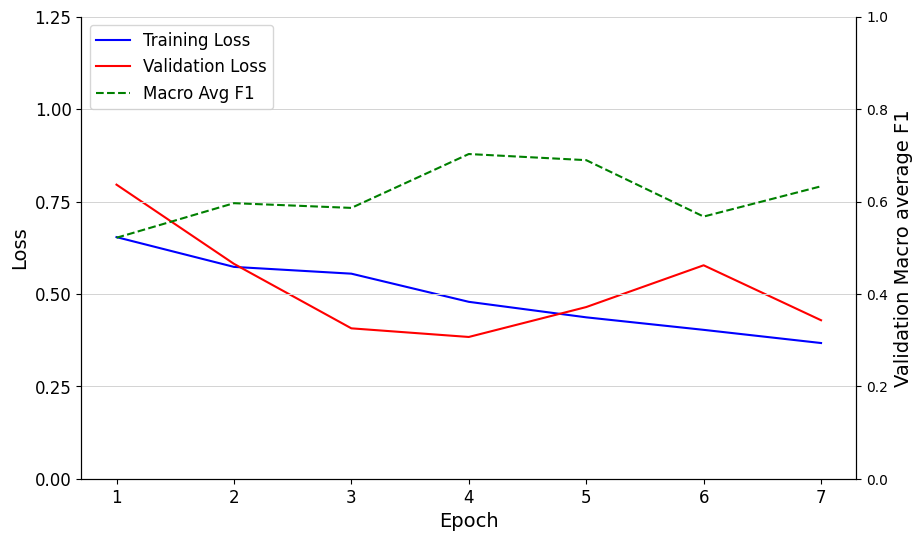

In [ ]:
N_EPOCHS = 20

train_losses = []
valid_losses = []
macro_f1_scores = []
total_steps = 0

for epoch in range(N_EPOCHS):
    train_loss, train_acc, steps_in_epoch = train(classifier_model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, epoch_macro_f1 = evaluate(classifier_model, valid_loader, criterion)
    total_steps += steps_in_epoch

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    macro_f1_scores.append(epoch_macro_f1)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'\t Val. Macro Avg F1 score: {epoch_macro_f1:.2f}')

classifier_model.cpu()
torch.save(classifier_model.state_dict(), SAVE_WEIGHTS_PATH)
torch.save(classifier_model.tcn.state_dict(), SAVE_CONVNET_WEIGHTS_PATH)
print('Model weights saved')
print('Total steps: ', total_steps)

plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS+1), train_losses, color='blue', label='Training Loss')
plt.plot(range(1, N_EPOCHS+1), valid_losses, color='red', label='Validation Loss')

plt.xticks(range(1, N_EPOCHS+1))
max_loss = max(max(train_losses), max(valid_losses))
max_val = round(max_loss + 0.5, 1)
LARGE_TICK_SPACING = True
if not LARGE_TICK_SPACING:
  yticks = [i for i in np.arange(0, max_val, 0.5)]
else:
  yticks = [i for i in np.arange(0, max_val, 0.25)]
plt.yticks(yticks)

for y in yticks:
    plt.axhline(y, color='lightgrey', linewidth=0.7)

ax = plt.gca()
ax.spines['right'].set_color('black')
ax.spines['top'].set_visible(False)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax2 = ax.twinx()
ax2.plot(range(1, N_EPOCHS+1), macro_f1_scores, color='green', label='Macro Avg F1', linestyle='--')
ax2.set_ylabel('Validation Macro average F1', fontsize=14)
ax2.set_ylim(0, 1)  # since F1 score range is [0, 1]
ax2.tick_params(axis='y', labelcolor='black')
ax2.spines['top'].set_visible(False)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=12)

plt.savefig(SAVE_PLOT_IMG_PATH)
print('Plot of loss saved')
plt.show()